In [10]:
import mesa
import random
import pickle
import time
import seaborn as sns
import numpy as np
import pandas as pd
import math
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import folium
import folium.plugins
import panel as pn
import panel.widgets as pnw
pn.extension()
import threading
import statistics
import streamlit as st
from streamlit_folium import st_folium

import warnings
warnings.filterwarnings('ignore')

In [11]:
class MaleAdult(mesa.Agent):

    def __init__(self, abandoned, borders, homesickness, home, unique_id, model):
        # Pass the parameters to the parent class.
        super().__init__(unique_id, model)

        self.infected = False
        self.days = None
        self.antibody = 0
        self.abandoned = abandoned
        self.borders = borders
        self.homesickness = homesickness
        self.home = home
        self.iter = 0
        
    def step(self):
        self.iter += 1
        if self.antibody > 0 and not self.infected:
            self.antibody -= 1
            #if self.antibody == 0:
            #   print(f"I'm agent {str(self.unique_id)} in {str(self.pos)} and I can be infected again") 
            #else:
            #    print(f"I'm agent {str(self.unique_id)} in {str(self.pos)} and I currently have antibodies for {str(self.antibody)} more days") 
        
        if self.infected:
            if self.days is None:
                self.days = self.model.recovery_days
            a = random.randint(1,100)
            if a <= self.model.cont_rate:
                other_agent = self.random.choice(self.model.grid.get_cell_list_contents([self.pos]))
                if other_agent is not None and not other_agent.infected and other_agent.antibody == 0:
                    #print(f"I'm agent {str(self.unique_id)} in {str(self.pos)} and I spread the infection to {str(other_agent.unique_id)} which is in {str(other_agent.pos)}")
                    other_agent.infected = True
                    #other_agent.days = model.recovery_days
                    self.model.num_infected += 1
            
            #print(f"I'm agent {str(self.unique_id)} in {str(self.pos)} and i'm infected, let's see if I die")
            b = random.randint(0,1000)
            if self.antibody > 0: #vaccination
                b/=2
            if b < (self.model.death_rate*10):
                #print(f"I'm agent {str(self.unique_id)} in {str(self.pos)} and I'm dead")
                self.model.kill_agents.append(self)
            else:
                if self.days is not None:
                    self.days -= 1
                    if self.days == 0:
                        #print(f"I'm agent {str(self.unique_id)} in {str(self.pos)} and I'm cured")
                        self.infected = False
                        self.days = None
                        self.model.num_infected -= 1
                        self.antibody = self.model.antibody_days
        
        if self.antibody == 0 and self.model.vaccination and self.iter >= self.model.vac_active:
            
            c = random.randint(1,100)
            if c <= self.model.vac_perc:
                self.antibody = self.model.vac_eff
        self.move()
                    
    def move(self):
        if self.borders is True and (self.model.move_inf or not self.infected or self.days >= math.ceil(2*self.model.recovery_days/3)):
            neighborhoods = self.model.grid.get_neighborhood(
                self.pos,
                include_center=False)
            
            if self.abandoned:
                possible_steps = neighborhoods
            else:
                possible_steps = [city for city in neighborhoods if city not in model.dead_cities]
                if not possible_steps:
                    return
                
            if self.homesickness and self.pos != self.home:
                if len(self.model.G.nodes[self.home]['agent']) > 0:
                    new_position = self.home
                else:
                    self.homesickness = False
                    new_position = self.random.choice(possible_steps)    
                    if self.home not in model.dead_cities:
                        model.dead_cities.append(self.home)
            else:
                new_position = self.random.choice(possible_steps)
            
            
            distance = self.model.G[self.pos][new_position]["KM_TOT"]
            pop = len(self.model.G.nodes[new_position]['agent'])
            total_pop = self.model.total_agents
            
        
            if self.abandoned is True or pop > 0:
                prob_mov = 10 + (100*pop)/(4*distance*total_pop)
                r = random.randint(1, 100)
                if prob_mov >= r:
                     #print(f"I'm agent {str(self.unique_id)} and I moved")
                     #print("Actual position: " + self.pos)
                      #print("New position: " + new_position)
                      #print("Value of r: " + str(r))
                      #print("Probability of moving: " + str(prob_mov))
                      #print("Distance: " + str(distance) + " Population: " + str(pop))
                     self.model.grid.move_agent(self, new_position)        
            else:
                model.dead_cities.append(new_position)

In [12]:
with open('distances.gpickle', 'rb') as f:
    G = pickle.load(f)

In [13]:
class NetworkInfectionModel(mesa.Model):

    def __init__(self, G, death_rate=5, recovery_days=5, antibody_days=10, cont_rate=20, init_rate = 1, abandoned = True, borders = True, homesickness = False, 
                 move_inf = True, vaccination = False, vac_active = 100, vac_perc = 1, vac_eff = 60):
        super().__init__()
        self.recovery_days = recovery_days
        self.antibody_days = antibody_days
        self.death_rate = death_rate
        self.cont_rate = cont_rate
        self.num_infected = 0
        self.num_dead = 0
        self.total_agents = 0
        self.steps = 0
        self.abandoned = abandoned
        self.borders = borders
        self.homesickness = homesickness
        self.move_inf = move_inf
        self.vaccination = vaccination
        self.vac_active = vac_active
        self.vac_perc = vac_perc
        self.vac_eff = vac_eff
        
        self.lat = []
        self.lng = []
        
        self.dead_cities = []

        self.G = G
        self.grid = mesa.space.NetworkGrid(self.G)

        self.schedule = mesa.time.RandomActivation(self)
        self.kill_agents = []

        # Create agents
        for i, node in enumerate(self.G.nodes(data = True)):
            node_dict = node[1]
            node_lat = node_dict.get('lat')
            #if node_lat is None:
            #    print("We: " + node[0])
            node_lng = node_dict.get('lng')
            self.lat.append(node_lat)
            self.lng.append(node_lng)
            population = node_dict['popolazione']
            #print(node[0] + " will have "+ str(round(population/1000)) + " agents")
            for x in range(math.ceil(population/1000)):
               a = MaleAdult(self.abandoned, self.borders, self.homesickness, node[0], i+1, self)
               self.schedule.add(a) 
               self.total_agents += 1
               self.grid.place_agent(a, node[0])
               r = random.randint(0, 100)
               if r <= init_rate:
                   a.infected = True
                   self.num_infected += 1
                   a.days = self.recovery_days
                    
            self.datacollector = mesa.DataCollector(
            model_reporters={"Total Agents": "total_agents", "Infected": "num_infected", "Dead": "num_dead"},
            agent_reporters={"Position": "pos", "Infected": "infected"})
            #self.datacollector.collect(self)

    def step(self):
        self.schedule.step()
        for x in self.kill_agents[:]:
            self.grid.remove_agent(x)
            self.schedule.remove(x)
            self.kill_agents.remove(x)
            self.num_infected -= 1 
            self.num_dead += 1
            self.total_agents -= 1
        self.running = True
        self.datacollector.collect(self)
        #print(f"Current number of total agents is: {str(self.total_agents)}")
        #print(f"Current number of infected agents is: {str(self.num_infected)}")
        #print(f"Current number of dead agents is: {str(self.num_dead)}")
        #for node in enumerate(self.G.nodes(data = True)):
        #   print(node[1][0] + ": " + str(len(node[1][1]['agent'])))         

In [14]:
model = NetworkInfectionModel(G)

In [15]:
def city_map():
    latitude = statistics.mean(model.lat)
    longitude = statistics.mean(model.lng)

    province_map = folium.Map(width=600, height=600, location=[latitude, longitude], zoom_start=10)


    # loop through the dataframe and add each data point to the mark cluster
    for node in enumerate(model.G.nodes(data = True)):
            node_dict = node[1][1]
            lat = node_dict.get('lat')
            lng = node_dict.get('lng')
            infected = 0
            agent_list = node_dict.get('agent')
            pop = len(agent_list)
            for agent in agent_list:
                if agent.infected:
                    infected += 1
            if pop == 0:
                color = 'gray'
            elif 0 < pop <= 5:
                color = 'blue'
            elif 5 < pop < 20:
                color = 'orange'
            else:
                color = 'red'
            #print(node[1][0])
            folium.CircleMarker(
            location=[lat, lng],
            radius=10,
            fill=True,
            color = color,
            popup=folium.Popup(f"{node[1][0]}<br>Infected: {str(infected)}<br>Total: {str(pop)}", max_width=300),
        ).add_to(province_map)

    return province_map

In [16]:
def create_agents_dataframe(G):
    # Lista per memorizzare i dati delle città e dei rispettivi conteggi di agenti
    city_data = []

    # Itera su tutti i nodi del grafo
    for node in G.nodes(data=True):
        city_name = node[0]  # Supponendo che il nome della città sia memorizzato in 'name'
        num_agents = len(node[1]['agent'])  # Conta il numero di agenti nella lista
        city_data.append({'City': city_name, 'Number of Agents': num_agents})

    # Crea un DataFrame dai dati raccolti
    agents_df = pd.DataFrame(city_data)
    
    return agents_df

In [17]:
def plot_agents_histogram(agents_df, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))  # Aumenta la larghezza della figura

    # Creazione dell'istogramma con barre orizzontali
    sns.barplot(y='City', x='Number of Agents', data=agents_df, ax=ax, dodge=True)

    # Configurazione del grafico
    ax.set_title("Number of Agents per City", fontsize=18)
    ax.set_xlabel("Number of Agents", fontsize=14)
    ax.set_ylabel("City", fontsize=14)

    # Regolare i margini per evitare che i nomi delle città vengano tagliati
    plt.xticks(fontsize=10)  # Dimensione del font per le etichette degli agenti
    plt.yticks(rotation=0, fontsize=10)  # Dimensione del font e ruota le etichette delle città
    plt.subplots_adjust(left=0.25)  # Aumenta il margine sinistro per dare spazio

    # Imposta i limiti fissi per l'asse X
    ax.set_xlim(0, 100)  # Sostituisci 100 con il valore massimo che desideri visualizzare

    # Aggiungi un margine verticale tra le barre
    for p in ax.patches:
        p.set_height(p.get_height() - 0.1)  # Riduci l'altezza della barra
        p.set_y(p.get_y() + 0.05)  # Sposta la barra in giù

    plt.tight_layout()
    
    return ax  # Restituisce l'asse per l'aggiornamento

def update_histogram(agents_df):
    global histogram_ax
    if histogram_ax is None:
        fig, histogram_ax = plt.subplots(figsize=(16, 10))  # Crea un nuovo asse se non esiste

    histogram_ax.clear()  # Pulisce l'asse senza cancellare la figura
    plot_agents_histogram(agents_df, histogram_ax)  # Aggiorna il grafico
    histogram_panel.object = histogram_ax.figure  # Aggiorna l'oggetto del pannello

Column(sizing_mode='stretch_width')
    [0] Row
        [0] Column
            [0] WidgetBox
                [0] Button(button_type='primary', name='Run', width=200)
                [1] Button(button_type='warning', name='Pause', width=200)
                [2] StaticText(name='Current Step', value='0')
                [3] FloatSlider(end=5, name='Death Rate', value=0.5, width=200)
                [4] IntSlider(end=30, name='Recovery Days', start=1, value=5, width=200)
                [5] IntSlider(end=30, name='Antibody Days', value=7, width=200)
                [6] IntSlider(end=100, name='Cont. Rate', start=1, value=20, width=200)
                [7] IntSlider(end=100, name='Init. Rate', start=1, value=1, width=200)
                [8] IntSlider(end=2000, name='Steps', start=5, value=20, width=200)
                [9] FloatSlider(end=2, name='Delay', width=200)
                [10] Checkbox(name='Move to Abandoned City')
                [11] Checkbox(name='Open Borders', value=True)
                [12] Checkbox(name='Home Sickness', value=True)
                [13] Checkbox(name='Infected Can M..., value=True)
                [14] Checkbox(name='Activate Vaccination')
                [15] IntSlider(end=2000, name='Vaccination a..., start=1, value=1, width=200)
                [16] IntSlider(end=100, name='Percentage of V..., start=1, value=1, width=200)
                [17] IntSlider(end=100, name='Antibody Days V..., start=1, value=1, width=200)
        [1] Folium(Map, height=600, sizing_mode='fixed', width=600)
        [2] Matplotlib(Figure, height=300, sizing_mode='fixed', width=400)
    [1] Matplotlib(Figure, height=600, sizing_mode='fixed', width=800)
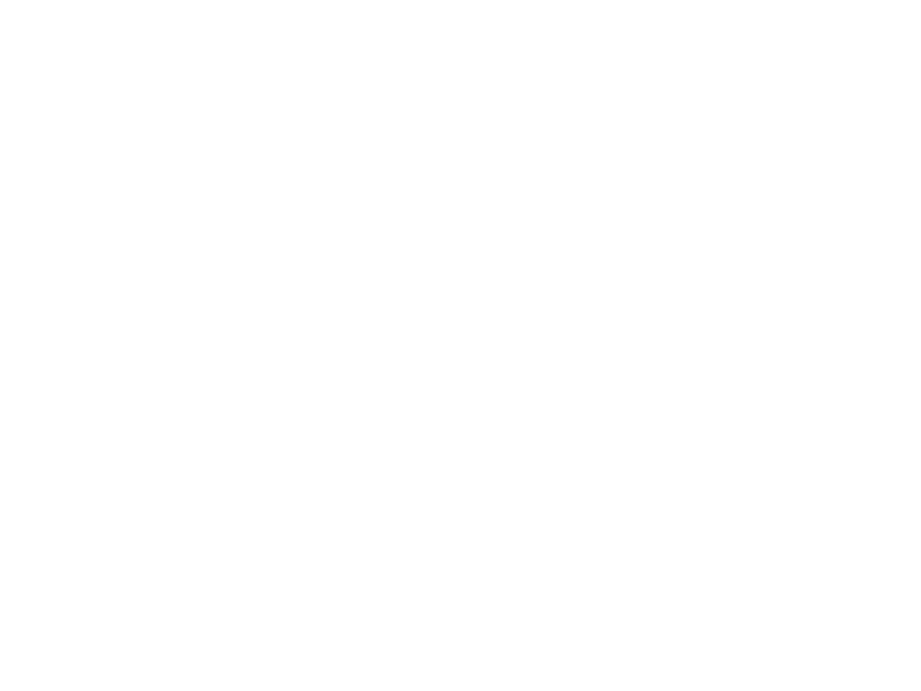
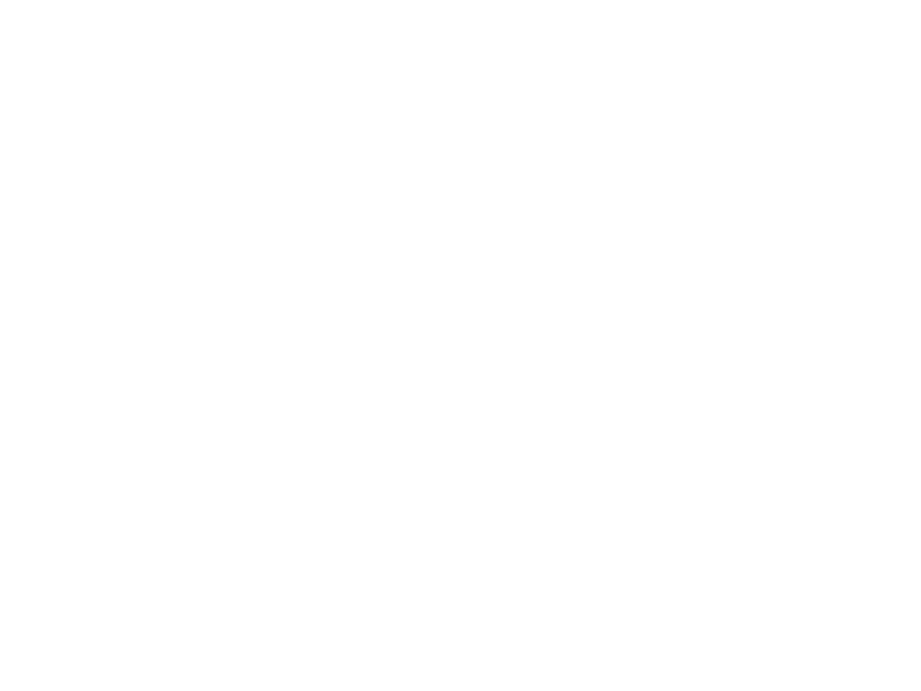

In [18]:
def toggle_pause(event):
    global is_paused
    is_paused = not is_paused
    pause_btn.name = 'Resume' if is_paused else 'Pause'

def run_model_thread(model, death, recovery, antibody, cont, init, steps, delay, abandoned, borders, home, move_inf, vaccination, vac_active, vac_perc, vac_eff):
    global current_step, is_paused

    # Crea un nuovo modello
    model = NetworkInfectionModel(G, death_rate=death, recovery_days=recovery, antibody_days=antibody, cont_rate=cont, init_rate=init, abandoned=abandoned, borders = borders, homesickness = home, move_inf = move_inf, vaccination = vaccination, vac_active=vac_active, vac_perc = vac_perc, vac_eff = vac_eff)

    # Reset del contatore degli step
    current_step = 0

    # Creazione di una figura per il grafico di Seaborn
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.set_title("Agents Status Over Time")
    ax.set_xlabel("Step")
    ax.set_ylabel("Number of Agents")

    # Ciclo di esecuzione del modello
    for i in range(steps):
        while is_paused:
            time.sleep(0.1)
        # Esegui uno step del modello
        model.step()
        
        current_step += 1
        step_counter.value = f'{current_step}'

        # Aggiorna i dati del grafico di Seaborn
        agents = model.datacollector.get_model_vars_dataframe()
        num_infected = agents['Infected'].iloc[-1]
        num_dead = agents['Dead'].iloc[-1]
        num_total = agents['Total Agents'].iloc[-1]
        ax.clear()  # Pulisce l'asse senza cancellare la figura
        sns.lineplot(x=agents.index, y=agents['Infected'], ax=ax, label=f"Infected \n(Last: {num_infected})")
        sns.lineplot(x=agents.index, y=agents['Dead'], ax=ax, label=f"Dead \n(Last: {num_dead})")
        sns.lineplot(x=agents.index, y=agents['Total Agents'], ax=ax, label=f"Total Agents \n(Last: {num_total})")
        ax.set_title("Agents Status Over Time")
        ax.set_xlabel("Step")
        ax.set_ylabel("Number of Agents")
        
        agents_df = create_agents_dataframe(model.G)
        update_histogram(agents_df)

        # Aggiorna il grafico
        states_pane.object = fig
        states_pane.param.trigger('object')
        
        updated_map = city_map()  # Assicurati che crime_map accetti il modello come parametro
        grid_pane.object = updated_map
        grid_pane.param.trigger('object')

        # Aggiungi un ritardo per la visualizzazione
        time.sleep(delay)
        
        if num_infected <= 0:
            break
    
    position_csv = model.datacollector.get_agent_vars_dataframe().reset_index().pivot(index='AgentID', columns='Step', values='Position')
    position_csv.to_csv('position.csv', index=False)

    infected_csv = model.datacollector.get_agent_vars_dataframe().reset_index().pivot(index='AgentID', columns='Step', values='Infected')
    infected_csv.to_csv('infected.csv', index=False)
    #csv =  model.datacollector.get_agent_vars_dataframe().reset_index().pivot(index='AgentID', columns='Step', values='Position')
    #csv.to_csv('agents.csv', index=False)

# Impostazioni iniziali
current_step = 0
is_paused = False
province_map = city_map()
grid_pane = pn.pane.plot.Folium(province_map, height=600, width=600)
states_pane = pn.pane.Matplotlib(plt.Figure(), width=400, height=300)


histogram_ax = None
agents_df = create_agents_dataframe(model.G)
histogram_panel = pn.pane.Matplotlib(plt.Figure(), width=800, height=600) 

step_counter = pnw.StaticText(name='Current Step', value=f'{current_step}')
go_btn = pnw.Button(name='Run', width=200, button_type='primary')
pause_btn = pnw.Button(name='Pause', width=200, button_type='warning')
pause_btn.on_click(toggle_pause)
death_input = pnw.FloatSlider(name='Death Rate', value=0.5, start=0, end=5, step=0.1, width=200)
recovery_input = pnw.IntSlider(name='Recovery Days', value=5, start=1, end=30, width=200)
antibody_input = pnw.IntSlider(name='Antibody Days', value=7, start=0, end=30, width=200)
cont_input = pnw.IntSlider(name='Cont. Rate', value=20, start=1, end=100, step=1, width=200)
init_input = pnw.IntSlider(name='Init. Rate', value=1, start=1, end=100, step=1, width=200)
steps_input = pnw.IntSlider(name='Steps', value=20, start=5, end=2000, width=200)
delay_input = pnw.FloatSlider(name='Delay', value=0, start=0, end=2, step=0.1, width=200)
abandoned_input = pnw.Checkbox(name='Move to Abandoned City', value=False)
borders_input = pnw.Checkbox(name='Open Borders', value=True)
home_input = pnw.Checkbox(name='Home Sickness', value=True)
move_inf_input = pnw.Checkbox(name='Infected Can Move after 1/3 Recovery', value=True)
vaccination_input = pnw.Checkbox(name='Activate Vaccination', value=False)
vac_active_input = pnw.IntSlider(name='Vaccination after # Steps', value=1, start=1, end=2000, width=200)
vac_perc_input = pnw.IntSlider(name='Percentage of Vaccination', value=1, start=1, end=100, width=200)
vac_eff_input = pnw.IntSlider(name='Antibody Days Vaccination', value=1, start=1, end=100, width=200)
widgets = pn.WidgetBox(go_btn, pause_btn, step_counter, death_input, recovery_input, antibody_input, cont_input, init_input, steps_input, delay_input, abandoned_input, borders_input, home_input, move_inf_input, vaccination_input, vac_active_input, vac_perc_input, vac_eff_input)

def execute(event):
    # Esegui il modello in un thread separato
    threading.Thread(target=run_model_thread, args=(model, death_input.value, recovery_input.value,
                                                    antibody_input.value, cont_input.value, init_input.value, steps_input.value, delay_input.value, abandoned_input.value, borders_input.value, home_input.value, move_inf_input.value, vaccination_input.value, vac_active_input.value, vac_perc_input.value, vac_eff_input.value), daemon=True).start()

go_btn.param.watch(execute, 'clicks')

# Configura il layout
layout = pn.Column(pn.Row(pn.Column(widgets), grid_pane, states_pane), histogram_panel, sizing_mode='stretch_width')
layout.servable()